In [1]:
# import modin.pandas as pd
import pandas as pd
import numpy as np
from Utilities.dataimport import ImportData
import dateparser as dp

In [2]:
output_files = '/Users/bradkittrell/Desktop/smartphones/brands'
data = ImportData(output_files)
df = data.combineCSV().drop_duplicates(subset='title')
df.to_csv('df.csv')

In [3]:
#extensive date cleaning is required for the release date. that is handled here
#generate features with regex
import time
import datetime as dt
today = dt.datetime.now()
date_dictionary = {'Q1':'January','Q2':'April','Q3':'July','Q4':'September','3Q':'July','Sep':'September','Oct':'October'}

df.released = df.released.str.replace(r'(\w.+(Released ))',"")
df.released = df.released.str.replace(r'((Exp\. announcement ))',"")
df.released = df.released.str.replace(r'((Not).*)',"")
df['releaseYear'] = df.released.str.extract(r'(\d+)')
df['releaseMonth'] = df.released.str.extract(r'((?<=\, )\w+)')

df.replace({'releaseMonth': date_dictionary},inplace=True)
df['released'] = pd.to_datetime(df.releaseYear+" "+df.releaseMonth,format='%Y %B')
df['ageInYears'] = (today-df.released)/np.timedelta64(1,'Y')


In [4]:
#generate features with regex
import re
import time
import datetime as dt
today = dt.datetime.now()
"""
extract data from the scraped columns using regex

"""
df['lowPrice'] = df.basePrice.str.replace(r'(\u2009)|(\,)',"")

df['lowPriceUSD'] = df.lowPrice.str.extract(r'((?<=\$)\w+.\d+)').astype('float64').fillna(0)
df['batteryEnergy'] = df.batterySize.str.extract(r'(\d+)').astype('float64').fillna(0)
df['frontCameraMP'] = df.frontCamera.str.extract(r'(\d+(?=\sMP))').astype('float64').fillna(0)
df['memory'] = df.memory.str.replace(r'(\((.*?)\))',"")
df['pricing'] = df.pricing.str.replace(r'((\xE2)..)','')
# df['memory'] = df.memory.str.replace(r'(.\w+.(RAM)|\w+.\w+.(RAM)|.\w+.(ROM))',"")
# df['memory'] = df.memory.str.replace(r'(\w.*(\/)\w+)',"")
df['baseCapacitySize'] = df.memory.str.extract(r'(\d+)')[0].astype('float64').fillna(0)
df['operatingSystem'] = df.opSys.str.extract(r'(\w+)')[0]
df['screenSize'] = df.screen.str.extract(r'(\d+(\.\d))')[0].astype('float64').fillna(0)
df['screenBodyRatio'] = df.screen.str.extract(r'(\d+\.\d(?=\%))')[0].astype('float64').fillna(0)
df['brand'] = df.title.str.extract(r'(\w+)')[0].astype(str)
df['rearCameraCleaned'] = df.rearCamera.str.replace(r'((\u2424|\\r)|\((.*?)\))'," ")
df['numberOfRearLenses'] = df.rearCameraCleaned.str.count('MP')
df['rearCameraPrimaryMP'] = df.rearCameraCleaned.str.extract(r'(\d+.(?=MP))').astype('float64').fillna(0)
df['rearCameraMPList'] = df.rearCameraCleaned.str.findall(r'(\d+.(?=MP))')



# total_MP_List = []
# for index, row in df.iterrows():
#     summation_of_MP = 0
#     for i in row.rearCameraMPList:
#         summation_of_MP += int(i)
#     total_MP_List.append(summation_of_MP)

# df['rearCameraTotalMP'] = total_MP_List

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
brand_count = df.groupby(['brand'],as_index=False)['screenSize'].count().sort_values(by=['screenSize'],ascending=False).reset_index(drop=True)
brand_count.rename(columns={'screenSize':'Count'},inplace=True)
ax = sns.barplot(x='Count',y='brand',data=brand_count,palette='muted')
plt.xticks(np.arange(0, 1400, 100.0))
plt.title('Number of Devices')
ax.set_xlabel('Count',fontsize=13)
ax.set_ylabel('Brand',fontsize=13)
plt.savefig('out.png')
plt.show()


<Figure size 1000x600 with 1 Axes>

# going to break up data set, for now, into three buckets. traditional non-smartphones: under 3.5" screen size. Tablets are devices greater than 7.5" screen size. Smart phones is everthing in between

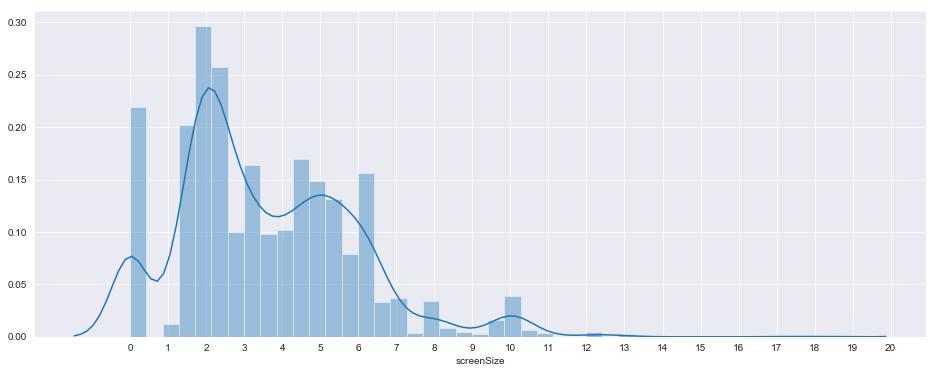

In [6]:
plt.figure(figsize=(16,6))
ax = sns.distplot(df.screenSize)

plt.xticks(np.arange(0, 21, 1.0))
plt.show()
##data frame split up
df_tablets = df[df.screenSize>7.5]
df_smartphones = df[(df.screenSize>=3.5) & (df.screenSize<=7.5)]
df_other = df[df.screenSize<3.5]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  if __name__ == '__main__':


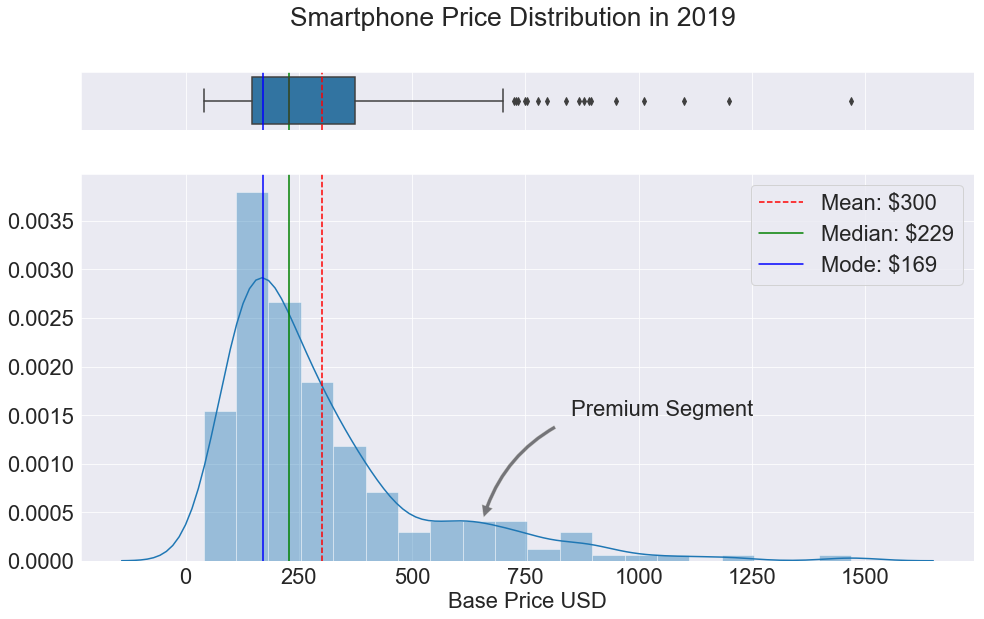

In [94]:
df_non_zero_smartphones = df_smartphones[(df_smartphones.lowPriceUSD>0)&(df_smartphones.lowPriceUSD<2000)].reset_index(drop=True)

plt.rcParams.update({'font.size': 22})

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(16,9), gridspec_kw= {"height_ratios": (0.15, 1)})

price_median = df_non_zero_smartphones.lowPriceUSD.median()
price_average = df_non_zero_smartphones.lowPriceUSD.mean()
price_mode = df_non_zero_smartphones.lowPriceUSD.mode().get_values()[0]


sns.boxplot(df_non_zero_smartphones.lowPriceUSD,ax=ax_box)
ax_box.axvline(price_average, color='r', linestyle='--')
ax_box.axvline(price_median, color='g', linestyle='-')
ax_box.axvline(price_mode, color='b', linestyle='-')
ax_box.set(xlabel='')


sns.distplot(df_non_zero_smartphones.lowPriceUSD,ax=ax_hist)
ax_hist.axvline(price_average, color='r', linestyle='--')
ax_hist.axvline(price_median, color='g', linestyle='-')
ax_hist.axvline(price_mode, color='b', linestyle='-')
ax_hist.annotate('Premium Segment', xy=(650, .0003),xytext=(850, .0015),arrowprops=dict(alpha=.5,facecolor='black', shrink=0.1,connectionstyle="arc3,rad=0.25"))
ax_hist.set(xlabel='Base Price USD')

plt.legend({'Mean: $%d'%price_average:price_average,'Median: $%d'%price_median:price_median,'Mode: $%d'%price_mode:price_mode})
plt.suptitle('Smartphone Price Distribution in 2019')
plt.savefig('smartphone price distribution.png')
plt.show()

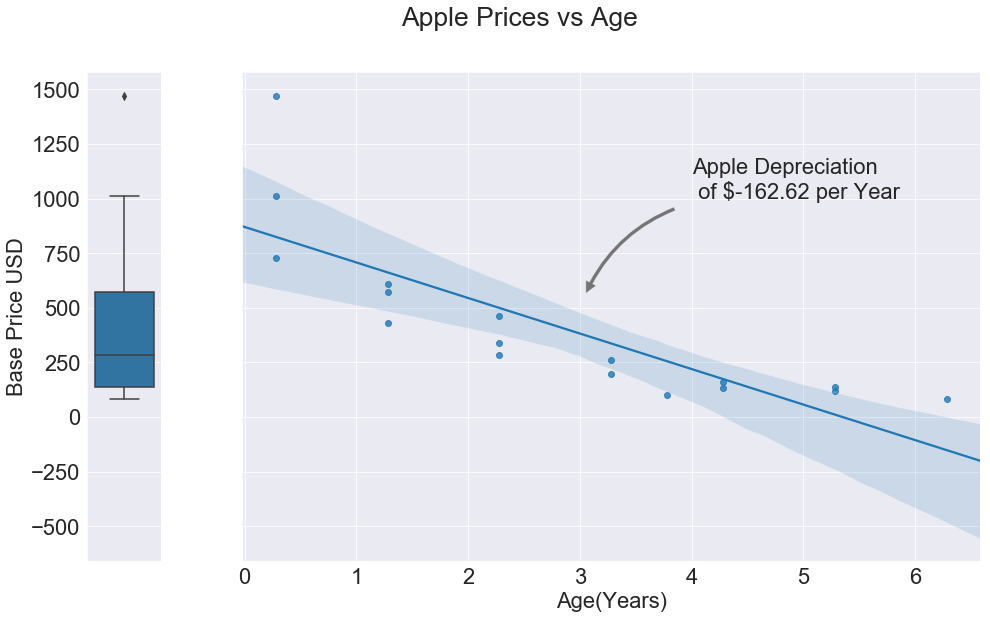

In [124]:
#iphone year vs price
plt.rcParams.update({'font.size': 22})
f, (ay_hist, ay_reg) = plt.subplots(nrows=1,ncols=2,figsize=(16,9),sharey=True, gridspec_kw= {"width_ratios": (0.10, 1)})
apple_df = df_non_zero_smartphones[df_non_zero_smartphones.brand=='Apple']

coeficient, intercept = np.polyfit(apple_df.ageInYears,apple_df.lowPriceUSD, deg=1)


sns.boxplot(df_non_zero_smartphones[df_non_zero_smartphones.brand=='Apple'].lowPriceUSD,ax=ay_hist,orient='v')
ay_hist.set(ylabel='Base Price USD')

sns.regplot(x='ageInYears',y='lowPriceUSD',data=df_non_zero_smartphones[df_non_zero_smartphones.brand=='Apple'],ax=ay_reg)
ay_reg.set(ylabel='',xlabel='Age(Years)')
ay_reg.annotate('Apple Depreciation\n of ${:.2f} per Year'.format(coeficient), xy=(3, 500),xytext=(4, 1000),arrowprops=dict(alpha=.5,facecolor='black', shrink=0.1,connectionstyle="arc3,rad=0.25"))
plt.suptitle('Apple Prices vs Age')
plt.savefig('Apple Prices vs age.png')
plt.show()


In [125]:
def regByCategory(data,on,x,y):
    '''
    gets simple fit of x and y but iterates over specific
    categories in a data set
    '''
    _on_list = data[on].unique()
    initial_list =[]
    for i in _on_list:
        filtered_data = data[data[on]==i]
        fit = np.polyfit(filtered_data[x],filtered_data[y],deg=1)
        _fit_list = [fit[0],fit[1],i]
        initial_list.append(_fit_list)
    output_df = pd.DataFrame(initial_list,columns=['coef','intercept',on])
    return output_df
    
depreciation = regByCategory(df_non_zero_smartphones,on='brand',x='ageInYears',y='lowPriceUSD')
depreciation['TimeToZero'] = depreciation.intercept/np.absolute(depreciation.coef)
depreciation

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


,coef,intercept,brand,TimeToZero
0,-162.624268,869.989349,Apple,5.349690
1,-183.046121,625.768985,Google,3.418641
2,-111.331972,470.201943,Huawei,4.223422
3,-132.932279,486.207596,LG,3.657559
4,-62.825820,408.254314,Samsung,6.498193
5,-80.158529,305.511280,Xiaomi,3.811338
6,11.437545,203.852126,Realme,17.823067
7,-294.334627,472.683547,Oppo,1.605939
8,-389.295055,454.547355,vivo,1.167617
9,-170.025284,563.469236,OnePlus,3.314032


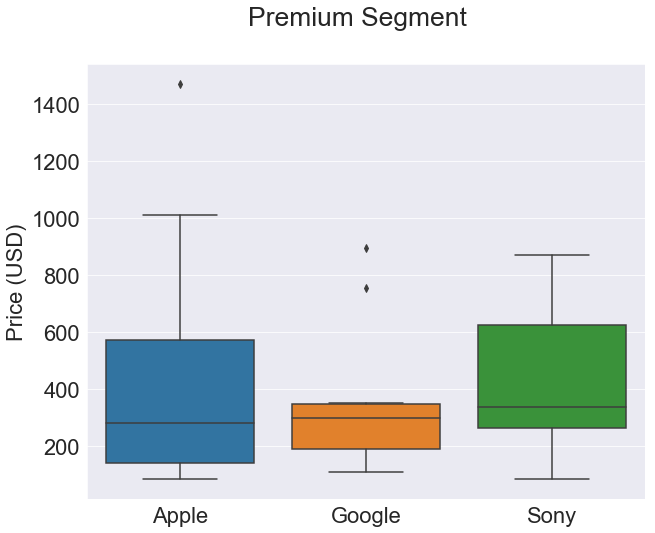

In [37]:
smartphone_brand_avg_price = df_non_zero_smartphones.groupby(['brand'],as_index=False)['lowPriceUSD'].mean().sort_values(by=['lowPriceUSD'],ascending=False).reset_index(drop=True)
smartphone_brand_avg_price.rename(columns={'lowPriceUSD':'Price'},inplace=True)



premium = df_non_zero_smartphones[df_non_zero_smartphones['brand'].isin(['Apple','Google','Sony'])]


plt.figure(figsize=(10,8))
ax = sns.boxplot(x='brand',y='lowPriceUSD',data=premium)
ax.set(xlabel='',ylabel='Price (USD)')
plt.suptitle('Premium Segment')
plt.show()

In [9]:
from sklearn import linear_model
from sklearn import metrics

def regression_scores(actual, prediction):
    '''
    print regresson model scores
    '''   
    dictionary = {'Mean Squared error':metrics.mean_squared_error(actual,prediction),
                 'R2 Score':metrics.r2_score(actual,prediction),
                 'Explained Variance':metrics.explained_variance_score(actual,prediction),
                 'Mean absolute error':metrics.mean_absolute_error(actual,prediction)}
    regression_scores_df = pd.DataFrame.from_dict(dictionary,orient='index')
    return regression_scores_df

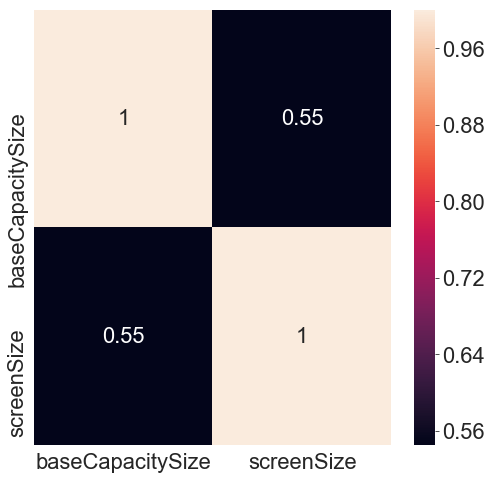

In [10]:
#dummy variables
dummy_manufacturers_df = pd.get_dummies(df_non_zero_smartphones.brand,drop_first=True)
# dummy_operating_system_df = pd.get_dummies(df_non_zero_smartphones.operatingSystem)
reduced_df = df_non_zero_smartphones[['baseCapacitySize','screenSize',]]
# temp_1_df = pd.concat([dummy_manufacturers_df,reduced_df],axis=1)
regression_df = pd.concat([dummy_manufacturers_df,reduced_df],axis=1)
actual_df = df_non_zero_smartphones.lowPriceUSD
plt.figure(figsize=(8,8))
corr=reduced_df.corr()
sns.heatmap(corr,annot=True)
plt.show()

In [26]:
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(regression_df,actual_df)
preds = reg.predict(regression_df)

coefficients = pd.DataFrame(reg.coef_,index=regression_df.columns)
# coefficients
regression_scores(actual_df,preds)

,0
Mean Squared error,21843.779404
R2 Score,0.572015
Explained Variance,0.572015
Mean absolute error,99.779736


In [27]:
import statsmodels.api as sm
X = sm.add_constant(regression_df)
model = sm.OLS(actual_df,X).fit()
model_prediction = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            lowPriceUSD   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     21.10
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           2.08e-33
Time:                        16:39:07   Log-Likelihood:                -1513.9
No. Observations:                 236   AIC:                             3058.
Df Residuals:                     221   BIC:                             3110.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -413.9547    139.581  

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [28]:
coefficients

,0
Google,-140.135542
Huawei,-294.127193
Infinix,-444.114380
LG,-292.230195
Nokia,-276.706341
OnePlus,-355.912853
Oppo,-320.592549
Realme,-350.183986
Samsung,-257.386628
Sony,-116.792609
